<a href="https://colab.research.google.com/github/fedorgrab/EAI6000/blob/master/assignment_3_street_view_house_numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [1]:
!pip install openml # Uncomment to run in Google Colab

In [2]:
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import time
import warnings
from contextlib import suppress
with suppress(Exception):
  %tensorflow_version 2.x
  
import tensorflow as tf
from tensorflow import keras

warnings.filterwarnings('ignore')
%matplotlib inline

TensorFlow 2.x selected.


In [0]:
plt.style.use("seaborn")

In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
# SVHN = oml.datasets.get_dataset(41081)

# X, y, cats, attrs = SVHN.get_data(dataset_format='array', target=SVHN.default_target_attribute)

In [0]:
# To save time, you can save the dataset to a Google drive, and load it quickly later
# from google.colab import drive
# drive.mount('/content/drive')

# with open("SVHN.pkl", "wb") as f:
#     pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
#     pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
#     pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

In [6]:
# (Uncomment to) Load SVHN dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')

with open("SVHN.pkl", "rb") as f:
    X = pickle.load(f)
    y = pickle.load(f)
    cats = pickle.load(f)
    attrs = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [7]:
X.shape

(99289, 3072)

In [76]:
class_labels = { i: i + 1 if i < 9 else 0  for i in range(10)}
class_labels

{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7, 7: 8, 8: 9, 9: 0}

1. Array X has 99289 images. 
2. Images are presented in one dimensional arrays, which have to be reshaped to 3 32x32 arrays.
3. That means that tensor has shape (99289, 3, 32, 32)

### You can use the following function to plot the first 10 images to get a sense of the data.

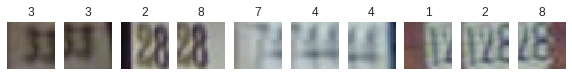

In [8]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32) / 255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]

plot_images(X[10:20], y[10:20])

### Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

To convert images to grayscale format I decided to choose Luminance method: weighted average of rgb channels with weights: 0.3R + 0.59G + 0.11B



In [0]:
X_g = X.reshape(99289, 32, 32, 3)

r, g, b = X_g[:,:,:, 0], X_g[:,:,:, 1], X_g[:,:,:,2]
X_g = ((0.3 * r + 0.59 * g + 0.11 * b) / 255).reshape(99289, 1024)

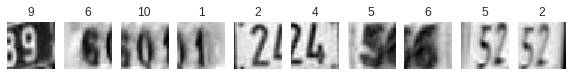

In [10]:
plot_images(X_g[50:60], y[50:60], grayscale=True)

### Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

In [0]:
import seaborn as sns
import pandas as pd

def dist_plot(values):
    val_counts = pd.Series(values).value_counts()
    plt.bar(val_counts.index, val_counts.values)
    plt.title("Number values distribution plot")
    plt.xlabel("Number")
    plt.ylabel("Amount of values")

In [0]:
import time
import functools

def time_it(func):

    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        print(f"--- {time.time() - start_time} seconds ---")
        return result

    return wrapper

In [0]:
from sklearn.model_selection import cross_validate, train_test_split

Xs, _, ys, _ = train_test_split(X_g, y, stratify=y, train_size=0.01)

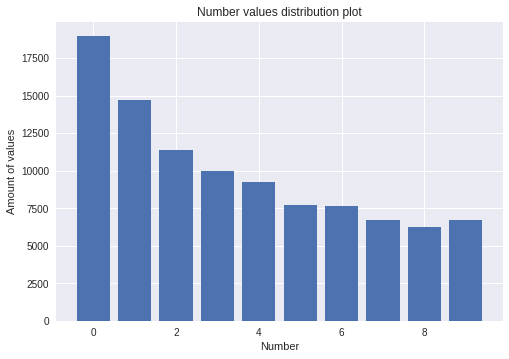

In [14]:
dist_plot(y)

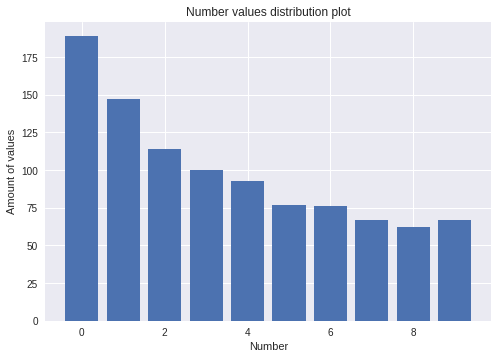

In [15]:
dist_plot(ys)

In [0]:
@time_it
def evaluate_learners(classifiers, X, y, number_of_folds=3):
    cross_validations = [
        cross_validate(model, X, y, return_train_score=True, cv=number_of_folds) 
        for model in classifiers
    ]

    return (
        list(map(lambda x: x["train_score"], cross_validations)),
        list(map(lambda x: x["test_score"], cross_validations))
    )


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

classifiers = [LogisticRegression(), KNeighborsClassifier(), LinearSVC()]
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

--- 39.778738260269165 seconds ---


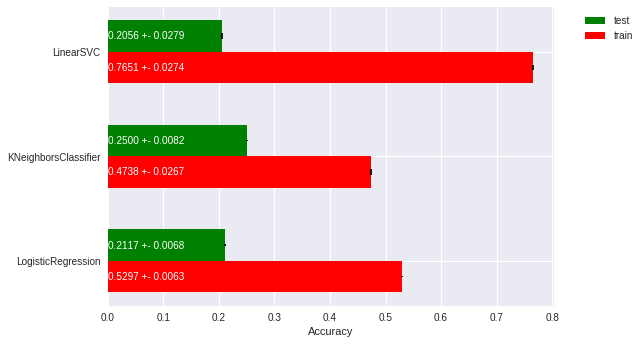

In [18]:
def plot_test_train_scores(train_scores, test_scores):
    fig, ax = plt.subplots()
    width=0.3

    ax.barh(
        np.arange(len(train_scores)), 
        np.mean(test_scores, axis=1),
        width,
        yerr=np.std(test_scores, axis=1), 
        color='green', 
        label='test'
    )
    ax.barh(
        np.arange(len(train_scores))-width, 
        np.mean(train_scores, axis=1), 
        width,
        yerr= np.std(train_scores, axis=1), 
        color='red', 
        label='train'
    )

    for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
        ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
        ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
        
    ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
    ax.set_xlabel('Accuracy')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2)


plot_test_train_scores(train_scores, test_scores)

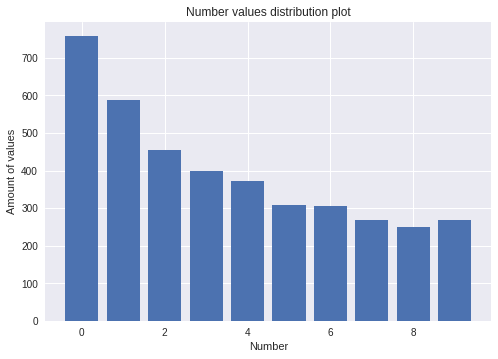

In [19]:
Xs, _, ys, _ = train_test_split(X_g, y, stratify=y, train_size=0.04)

dist_plot(ys)

In [20]:
train_scores, test_scores = evaluate_learners(classifiers, Xs, ys)

--- 285.22938418388367 seconds ---


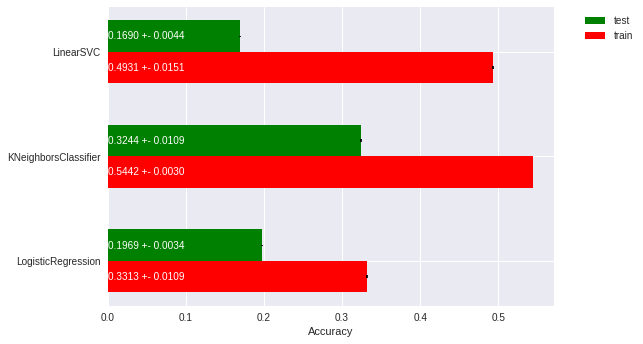

In [21]:
plot_test_train_scores(train_scores, test_scores)

Models are overfitted. I expected better results.

Increasing of sample size caused better result.

When sample size was bigger it took more time to evaluate modls. It was expected because more data you have more time machine needs to process it.

To increase accuracy we need to amend hyperparameters and include more data.

### Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1024,)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10)
])

In [0]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_g, y, train_size=0.8)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 264,970
Trainable params: 264,970
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.fit(X_train, y_train, epochs=20)

Train on 79431 samples
Epoch 1/20
79431/79431 [==============================] - 9s 115us/sample - loss: 2.0257 - accuracy: 0.2641
Epoch 2/20
79431/79431 [==============================] - 9s 109us/sample - loss: 1.6471 - accuracy: 0.4392
Epoch 3/20
79431/79431 [==============================] - 9s 109us/sample - loss: 1.5423 - accuracy: 0.4900
Epoch 4/20
79431/79431 [==============================] - 9s 108us/sample - loss: 1.5048 - accuracy: 0.5055
Epoch 5/20
79431/79431 [==============================] - 8s 107us/sample - loss: 1.4828 - accuracy: 0.5149
Epoch 6/20
79431/79431 [==============================] - 9s 108us/sample - loss: 1.4661 - accuracy: 0.5229
Epoch 7/20
79431/79431 [==============================] - 7s 88us/sample - loss: 1.4552 - accuracy: 0.5271
Epoch 8/20
79431/79431 [==============================] - 9s 107us/sample - loss: 1.4435 - accuracy: 0.5309
Epoch 9/20
79431/79431 [==============================] - 8s 106us/sample - loss: 1.4338 - accuracy: 0.5335
Epoch 

In [0]:
probability_model = tf.keras.Sequential(
    [model, tf.keras.layers.Softmax()]
)
predictions = model.predict_classes(X_test)
prediction_probabilities = probability_model.predict(X_test)

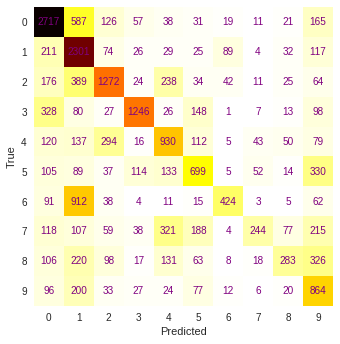

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(y_test, predictions)

def plot_conf_matrix(cm, labels, scale=None):
    fig, ax = plt.subplots()
    cm_scaled = None
    if scale:
        cm_scaled = cm.copy()
        cm_scaled[cm_scaled < cm_scaled.max() / 3] = cm_scaled[cm_scaled < cm_scaled.max() / 3] * scale
        
    if cm_scaled is None:
        im = ax.imshow(cm, cmap=plt.cm.hot_r)

    else:
        im = ax.imshow(cm_scaled)
    
    ax.grid(False)
    ax.set_xticks(list(class_labels.values()))
    ax.set_yticks(list(class_labels.values()))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_ylabel("True")
    ax.set_xlabel("Predicted")

    for i in range(100):
        if  cm[i%10, int(i/10)]:
            ax.text(
                int(i/10), i%10, cm[i%10,int(i/10)],
                 ha="center", va="center", color="purple"
            )

plot_conf_matrix(cm, list(class_labels.values()))

In [0]:
def plot_image(predictions_array, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = "blue"
  else:
    color = "red"

  plt.xlabel("{} {:2.0f}% ({})".format(
    class_labels[predicted_label],
    100*np.max(predictions_array),
    class_labels[true_label]
    ), color=color)

def plot_value_array(predictions_array, true_label):
  plt.grid(False)
  plt.xticks(np.arange(10), list(range(10)), rotation=90)
  plt.yticks([])
  ax = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  ax[predicted_label].set_color("red")
  ax[true_label].set_color("blue")

In [0]:
missclassified_query = y_test != predictions

missclassified_images = X_test[missclassified_query]
missclassified_actual_labels = y_test[missclassified_query]
missclassified_probabilities = prediction_probabilities[missclassified_query]

In [55]:
missclassified_images.shape

(8878, 1024)

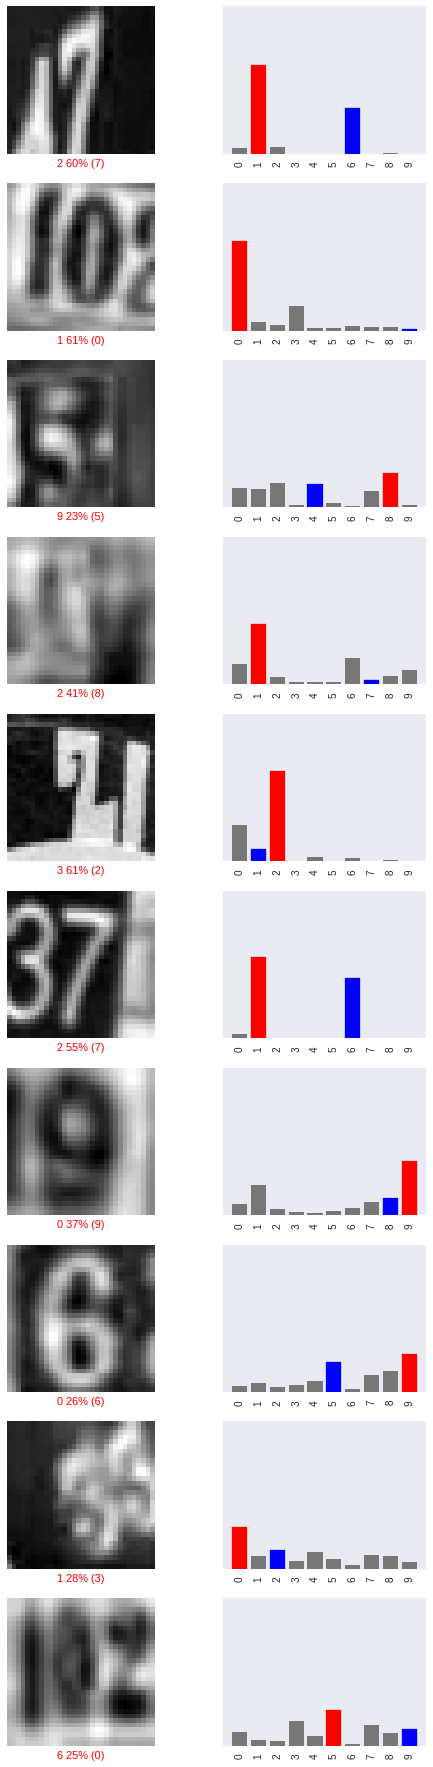

In [80]:
plt.figure(figsize=(8, 32))

for i in range(10):
    plt.subplot(10, 2, 2 * i + 1)
    plot_image(
      missclassified_probabilities[i], 
      missclassified_actual_labels[i],
      missclassified_images[i].reshape(32,32)
    )
    plt.subplot(10, 2, 2 * i + 2)
    plot_value_array(
      missclassified_probabilities[i], 
      missclassified_actual_labels[i]
    )

plt.show()

Unfortunately, I got only 55% of accuracy on training data, so test data would show even less.

Bonus challenge: 
Can you improve the model performance from this first Keras model?
If you wonder about how researchers get to 98% accuracy, here is a list of papers :)
https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#5356484e 

I decided to raise accuracy by image processing. So my point is that if I changed the image contrast it would be easier for model to classify the digit. Let's see how is it going to work.

In [41]:
X_c = X_g.reshape(101671936)
X_c.mean()

0.44753543

In [0]:
X_c[X_c > 0.5 ] = 1.0
X_c[X_c < 0.37] = 0.0
X_c = X_c.reshape(99289, 1024)

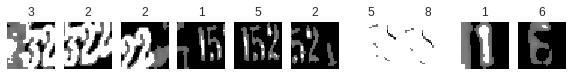

In [44]:
plot_images(X_c[34600:34610], y[34600:34610], grayscale=True)

In [0]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y, train_size=0.8)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1024,)),
    keras.layers.Dense(256, activation='sigmoid'),
    keras.layers.Dense(10)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [90]:
model.fit(X_train_c, y_train_c, epochs=10)

Train on 79431 samples
Epoch 1/10
79431/79431 [==============================] - 6s 75us/sample - loss: 1.6973 - accuracy: 0.4321
Epoch 2/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.2974 - accuracy: 0.5783
Epoch 3/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.1669 - accuracy: 0.6191
Epoch 4/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.0836 - accuracy: 0.6460
Epoch 5/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.0294 - accuracy: 0.6624
Epoch 6/10
79431/79431 [==============================] - 6s 72us/sample - loss: 0.9884 - accuracy: 0.6748
Epoch 7/10
79431/79431 [==============================] - 6s 72us/sample - loss: 0.9525 - accuracy: 0.6874
Epoch 8/10
79431/79431 [==============================] - 6s 71us/sample - loss: 0.9307 - accuracy: 0.6950
Epoch 9/10
79431/79431 [==============================] - 6s 71us/sample - loss: 0.9004 - accuracy: 0.7060
Epoch 10/10
79

In [91]:
from sklearn.metrics import accuracy_score

predictions_c = model.predict_classes(X_test_c)

accuracy_score(y_test_c, predictions_c)

0.6634102125088126

So that's better than 55% but still not good.

In [0]:
X_c_2 = X_g.reshape(101671936)
X_c_2[X_c_2 >= 0.75 ] = 0.875
X_c_2[(X_c_2 >= 0.50) & (X_c_2 < 0.75)] = 0.625
X_c_2[(X_c_2 >= 0.25) & (X_c_2 < 0.50)] = .375
X_c_2[(X_c_2 < 0.25)] = .125

X_c_2 = X_c_2.reshape(99289, 1024)

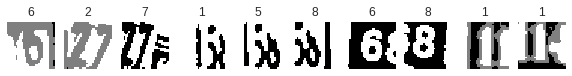

In [95]:
plot_images(X_c_2[1570:1580], y[1570:1580], grayscale=True)

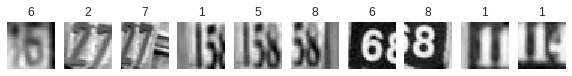

In [97]:
plot_images(X_g[1570:1580], y[1570:1580], grayscale=True)

In [0]:
X_train_c_2, X_test_c_2, y_train_c_2, y_test_c_2 = train_test_split(X_c_2, y, train_size=0.8)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1024,)),
    keras.layers.Dense(256, activation='sigmoid'),
    keras.layers.Dense(10)
])

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [103]:
model.fit(X_train_c_2, y_train_c_2, epochs=10)

Train on 79431 samples
Epoch 1/10
79431/79431 [==============================] - 6s 74us/sample - loss: 1.9996 - accuracy: 0.2987
Epoch 2/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.5568 - accuracy: 0.4856
Epoch 3/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.3380 - accuracy: 0.5641
Epoch 4/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.2119 - accuracy: 0.6090
Epoch 5/10
79431/79431 [==============================] - 6s 71us/sample - loss: 1.1255 - accuracy: 0.6381
Epoch 6/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.0625 - accuracy: 0.6575
Epoch 7/10
79431/79431 [==============================] - 6s 72us/sample - loss: 1.0151 - accuracy: 0.6721
Epoch 8/10
79431/79431 [==============================] - 6s 72us/sample - loss: 0.9772 - accuracy: 0.6842
Epoch 9/10
79431/79431 [==============================] - 6s 71us/sample - loss: 0.9449 - accuracy: 0.6950
Epoch 10/10
79

In [105]:
predictions_c_2 = model.predict_classes(X_test_c_2)

accuracy_score(y_test_c, predictions_c_2)

0.11793735522207674